# RandomForest 하이퍼 파라미터 튜닝

일반 분류 알고리즘의 튜닝 방법과 동일하다.

## #01. 준비작업

### [1] 패키지 가져오기

In [1]:
# 연결된 모듈이 업데이트 되면 즉시 자동 로드함
%load_ext autoreload
%autoreload 2

from hossam.util import *
from hossam.plot import *
from hossam.analysis import *
from hossam.regression import *

# 배깅 회귀
from sklearn.ensemble import RandomForestRegressor

# 하이퍼파라미터 튜닝 객체
from sklearn.model_selection import RandomizedSearchCV

### [2] 데이터 가져오기

In [2]:
origin = my_read_excel("https://data.hossam.kr/mldata/boston.xlsx", info=False)


상위 5개 행
+----+---------+------+---------+--------+-------+-------+-------+--------+-------+-------+-----------+--------+---------+--------+
|    |    CRIM |   ZN |   INDUS |   CHAS |   NOX |    RM |   AGE |    DIS |   RAD |   TAX |   PTRATIO |      B |   LSTAT |   MEDV |
|----+---------+------+---------+--------+-------+-------+-------+--------+-------+-------+-----------+--------+---------+--------|
|  0 | 0.00632 |   18 |    2.31 |      0 | 0.538 | 6.575 |  65.2 |   4.09 |     1 |   296 |      15.3 |  396.9 |    4.98 |     24 |
|  1 | 0.02731 |    0 |    7.07 |      0 | 0.469 | 6.421 |  78.9 | 4.9671 |     2 |   242 |      17.8 |  396.9 |    9.14 |   21.6 |
|  2 | 0.02729 |    0 |    7.07 |      0 | 0.469 | 7.185 |  61.1 | 4.9671 |     2 |   242 |      17.8 | 392.83 |    4.03 |   34.7 |
|  3 | 0.03237 |    0 |    2.18 |      0 | 0.458 | 6.998 |  45.8 | 6.0622 |     3 |   222 |      18.7 | 394.63 |    2.94 |   33.4 |
|  4 | 0.06905 |    0 |    2.18 |      0 | 0.458 | 7.147 |  54.2 | 

### [3] 훈련/검증 데이터 분할 및 데이터 표준화

In [3]:
x_train, x_test, y_train, y_test = my_train_test_split(origin, "MEDV", scalling=True)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((404, 13), (102, 13), (404,), (102,))

## #02. 랜덤포레스트 하이퍼 파라미터 튜닝

### [1] RandomizedSearchCV 적용

In [4]:
%%time

# RandomForest 분류기
estimator = RandomizedSearchCV(
    estimator=get_estimator(classname=RandomForestRegressor), 
    param_distributions=get_hyper_params(classname=RandomForestRegressor), 
    n_iter=get_max_iter(),
    n_jobs=get_n_jobs(),
    random_state=get_random_state(),
    cv=5
)

estimator.fit(x_train, y_train)
estimator

CPU times: total: 4.08 s
Wall time: 1min 27s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=0,
                                                   verbose=False),
                   n_iter=1000, n_jobs=-1,
                   param_distributions={'criterion': ['squared_error',
                                                      'absolute_error',
                                                      'friedman_mse',
                                                      'poisson'],
                                        'max_depth': [10, 20, 50, None],
                                        'max_features': ['sqrt', 'log2'],
                                        'n_estimators': [10, 20, 50, 100]},
                   random_state=0)

### [2] RandomizedSearchCV 결과 확인

In [5]:
result_df = DataFrame(estimator.cv_results_["params"])
result_df["mean_test_score"] = estimator.cv_results_["mean_test_score"]
result_df.dropna(subset=["mean_test_score"], inplace=True)
result_df.sort_values(by="mean_test_score", ascending=False, inplace=True)

result_df

,n_estimators,max_features,max_depth,criterion,mean_test_score
74,50,sqrt,20.0,friedman_mse,0.883206
78,50,log2,20.0,friedman_mse,0.883206
90,50,sqrt,NaN,friedman_mse,0.882938
82,50,sqrt,50.0,friedman_mse,0.882938
86,50,log2,50.0,friedman_mse,0.882938
...,...,...,...,...,...
120,10,sqrt,NaN,poisson,0.840019
112,10,sqrt,50.0,poisson,0.840019
124,10,log2,NaN,poisson,0.840019
104,10,sqrt,20.0,poisson,0.839754


### [3] 모델 성능 평가

컴퓨터 성능이 좋지 않을 경우 가장 부하가 큰 학습곡선 출력을 off 시킬 것

> `learning_curve=False` 파라미터 추가

[회귀분석 성능평가]
+-------------------------------+--------------+--------------+
|                               |   훈련데이터 |   검증데이터 |
|-------------------------------+--------------+--------------|
| 결정계수(R2)                  |     0.982076 |     0.654512 |
| 평균절대오차(MAE)             |     0.856853 |       2.8984 |
| 평균제곱오차(MSE)             |      1.52611 |      28.1326 |
| 평균오차(RMSE)                |      1.23536 |      5.30402 |
| 평균 절대 백분오차 비율(MAPE) |      4.29288 |      13.1031 |
| 평균 비율 오차(MPE)           |     -1.09142 |     -2.64469 |
+-------------------------------+--------------+--------------+

[학습곡선]


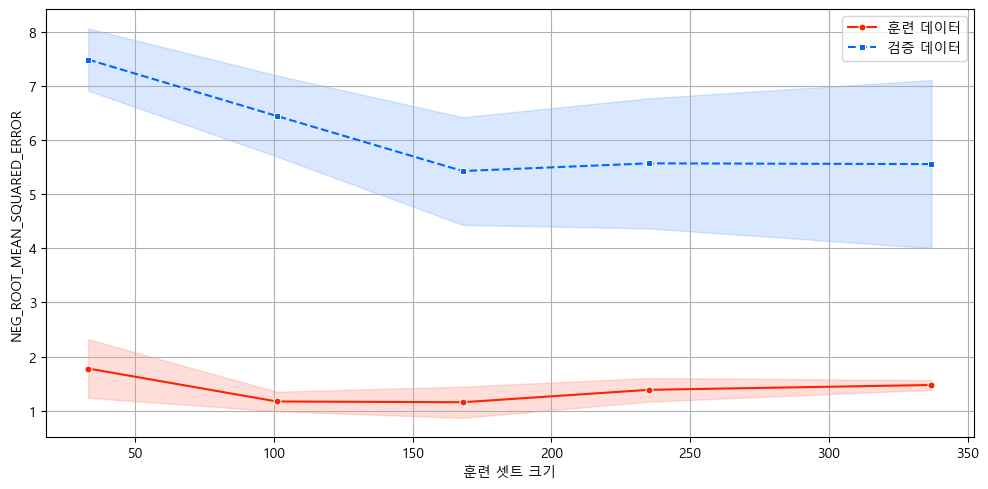

CPU times: total: 3.05 s
Wall time: 10min 14s


In [6]:
%%time
my_regression_result(
    estimator=estimator, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test
)

### [4] 독립변수 보고

In [7]:
%%time
my_regression_report(
    estimator=estimator, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test
)

+----+------------+------------+---------+
|    | 종속변수   | 독립변수   |     VIF |
|----+------------+------------+---------|
|  0 | MEDV       | CRIM       | 2.09518 |
|  1 | MEDV       | ZN         | 2.33731 |
|  2 | MEDV       | INDUS      |  4.9238 |
|  3 | MEDV       | CHAS       | 1.32047 |
|  4 | MEDV       | NOX        | 4.17384 |
|  5 | MEDV       | RM         | 1.82706 |
|  6 | MEDV       | AGE        | 2.93317 |
|  7 | MEDV       | DIS        | 4.41185 |
|  8 | MEDV       | RAD        | 9.98804 |
|  9 | MEDV       | TAX        | 10.5503 |
| 10 | MEDV       | PTRATIO    | 1.88398 |
| 11 | MEDV       | B          |  1.5563 |
| 12 | MEDV       | LSTAT      |  2.8052 |
+----+------------+------------+---------+

CPU times: total: 46.9 ms
Wall time: 50.9 ms


## #03. 모듈화 기능 확인

[교차검증 TOP5]
+----+----------------+----------------+-------------+----------------+-------------------+
|    |   n_estimators | max_features   |   max_depth | criterion      |   mean_test_score |
|----+----------------+----------------+-------------+----------------+-------------------|
|  0 |             50 | log2           |          50 | friedman_mse   |          0.882938 |
|  1 |            100 | log2           |          10 | squared_error  |          0.879718 |
|  2 |            100 | sqrt           |          50 | absolute_error |          0.875785 |
|  3 |            100 | log2           |         nan | poisson        |          0.874856 |
|  4 |             20 | sqrt           |          20 | friedman_mse   |          0.872629 |
+----+----------------+----------------+-------------+----------------+-------------------+

[Best Params]
{'n_estimators': 50, 'max_features': 'log2', 'max_depth': 50, 'criterion': 'friedman_mse'}

[회귀분석 성능평가]
+-------------------------------+--------

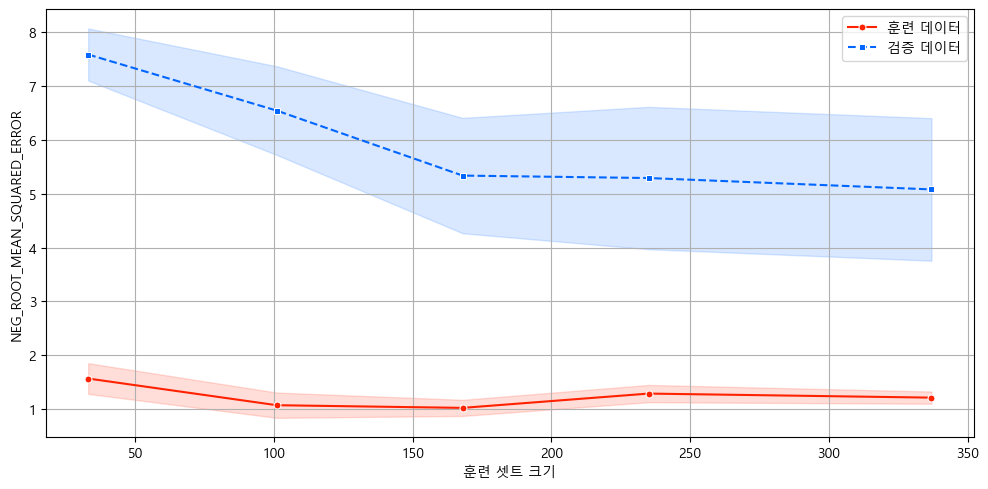


+----+------------+------------+---------+
|    | 종속변수   | 독립변수   |     VIF |
|----+------------+------------+---------|
|  0 | MEDV       | CRIM       | 2.09518 |
|  1 | MEDV       | ZN         | 2.33731 |
|  2 | MEDV       | INDUS      |  4.9238 |
|  3 | MEDV       | CHAS       | 1.32047 |
|  4 | MEDV       | NOX        | 4.17384 |
|  5 | MEDV       | RM         | 1.82706 |
|  6 | MEDV       | AGE        | 2.93317 |
|  7 | MEDV       | DIS        | 4.41185 |
|  8 | MEDV       | RAD        | 9.98804 |
|  9 | MEDV       | TAX        | 10.5503 |
| 10 | MEDV       | PTRATIO    | 1.88398 |
| 11 | MEDV       | B          |  1.5563 |
| 12 | MEDV       | LSTAT      |  2.8052 |
+----+------------+------------+---------+

CPU times: total: 1.09 s
Wall time: 6.13 s


RandomForestRegressor(criterion='friedman_mse', max_depth=50,
                      max_features='log2', n_estimators=50, n_jobs=-1,
                      random_state=0, verbose=False)

In [8]:
%%time
my_rf_regression(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)